In [170]:
import pandas as pd
import numpy as np
import helper_functions as hf
import pickle
import matplotlib.pyplot as plt
import importlib
import math
import copy
import re
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
import random
importlib.reload(hf)
import warnings
warnings.filterwarnings('ignore')

id_thresh = 99
data_dir = "C:/Users/ctata/Documents/Lab/quality_vectors_git/data/"
fig_dir = "C:/Users/ctata/Documents/Lab/quality_vectors_git/figures/"

otu = pd.read_csv(data_dir + "IBD_huttenhower/embed/seqtab_.07_100id_100dim.txt", sep = "\t")
print("OTU shape: " + str(otu.shape))

OTU shape: (274, 2581)


In [171]:
mapping = pd.read_csv(data_dir + "IBD_huttenhower/mapping.txt", sep = "\t")
print(mapping.shape)
mapping.visit_study_disease_name[mapping.visit_study_disease_name == "crohn's disease"] = "CD"
mapping.visit_study_disease_name[mapping.visit_study_disease_name == "ulcerative colitis"] = "UC"
mapping.visit_study_disease_name[mapping.visit_study_disease_name.isna()] = "HC"

embedded_99 = pd.read_csv(data_dir + "IBD_huttenhower/embed/embedded_.07_99id_100dim.txt", sep = "\t")
embedded_97 = pd.read_csv(data_dir + "IBD_huttenhower/embed/embedded_.07_97id_100dim.txt", sep = "\t")
embedded_100 = pd.read_csv(data_dir + "IBD_huttenhower/embed/embedded_.07_100id_100dim.txt", sep = "\t")

#sample_names = mapping.index.values[[i in otu.index.values for i in mapping.index.values]]
sample_names = mapping.index.values[[(i in otu.index.values) for i in mapping.index.values]]
print("sample names shape: " + str(len(sample_names)))
mapping = mapping.loc[[i in otu.index.values for i in mapping.index.values], :]
print(mapping.shape)
otu = otu.loc[mapping.index, :]
embedded_97 = embedded_97.loc[mapping.index, :]
embedded_99 = embedded_99.loc[mapping.index, :]
embedded_100 = embedded_100.loc[mapping.index, :]

print("OTU shape: " + str(otu.shape))
print("Map shape: " + str(mapping.shape))
print("Embedded shape 97: " + str(embedded_97.shape))
print("Embedded shape 99: " + str(embedded_99.shape))
print("Embedded shape 100: " + str(embedded_100.shape))

(197, 58)
sample names shape: 197
(197, 58)
OTU shape: (197, 2581)
Map shape: (197, 58)
Embedded shape 97: (197, 100)
Embedded shape 99: (197, 100)
Embedded shape 100: (197, 100)


In [172]:

#sample_names = otu.index.values[np.sum(otu, axis = 1) < 100000]
#otu = otu.loc[sample_names, :]
#mapping = mapping.loc[sample_names, :]
#embedded_97 = embedded_97.loc[sample_names, :]
#embedded_99 = embedded_99.loc[sample_names, :]
#embedded_100 = embedded_100.loc[sample_names, :]

In [173]:
from collections import Counter
print(np.sum([i == j for i,j in zip(mapping.index.values, otu.index.values)]))
print(np.sum([i == j for i,j in zip(mapping.index.values, embedded_97.index.values)]))
print(mapping.shape)
print(embedded_97.shape)
print(otu.shape)
print(Counter(mapping.visit_study_disease_name))

197
197
(197, 58)
(197, 100)
(197, 2581)
Counter({'CD': 111, 'UC': 44, 'HC': 42})


In [174]:
y_hut = [i in ["CD", "UC"] for i in mapping['visit_study_disease_name']]
mapping_hut = mapping
otu_hut = otu


In [175]:
#Process american gut data
#Load data
filt = ".07"
f = open("C:/Users/ctata/Documents/Lab/quality_vectors_final/data/AG_new/filter_.07//otu_train_" + str(filt) + ".obj", "rb")
otu_train_ag = pickle.load(f)
f.close()

f = open("C:/Users/ctata/Documents/Lab/quality_vectors_final/data/AG_new/filter_.07//otu_test_" + str(filt) + ".obj", "rb")
otu_test_ag = pickle.load(f)
f.close()

f = open("C:/Users/ctata/Documents/Lab/quality_vectors/data/AG_new/feces/map_train_strictDiag.obj", "rb")
map_train_ag = pickle.load(f)
f.close()

f = open("C:/Users/ctata/Documents/Lab/quality_vectors/data/AG_new/feces/map_test_strictDiag.obj", "rb")
map_test_ag = pickle.load(f)
f.close()

qual_vecs_ag, embed_ids, embed_seqs = hf.getQualVecs(data_dir)

otu_train_toembed = hf.matchOtuQual(otu_train_ag, qual_vecs_ag.index.values, embed_seqs)
otu_test_toembed = hf.matchOtuQual(otu_test_ag, qual_vecs_ag.index.values, embed_seqs)

data_ag = pd.concat([otu_train_toembed, otu_test_toembed])
print("Tax counts shape: " + str(data_ag.shape))
mapping_ag = pd.concat([map_train_ag, map_test_ag])
embedded_ag = pd.DataFrame(np.dot(hf.asinh(data_ag), qual_vecs_ag))
embedded_ag.columns = embedded_97.columns.values
print("Embedded shape: " + str(embedded_ag.shape))
y_ag = mapping_ag["IBD"].values

26726
26726
(26726, 100)
all good
all good
Tax counts shape: (5874, 26726)
Embedded shape: (5874, 100)


In [176]:
#Embed american gut data
embedded_train_ag = pd.DataFrame(np.dot(hf.asinh(otu_train_ag), qual_vecs_ag))
embedded_test_ag = pd.DataFrame(np.dot(hf.asinh(otu_test_ag), qual_vecs_ag))
y_train_ag = map_train_ag["IBD"].values
y_test_ag = map_test_ag["IBD"].values

In [177]:
asvs = [i for i in otu_hut.columns.values if i in otu_train_ag.columns.values]
otu_train_ag = otu_train_ag.loc[:, asvs]
otu_test_ag = otu_test_ag.loc[:, asvs]
otu_train_ag.shape

data_ag_reord = pd.concat([otu_train_ag, otu_test_ag])
data_ag_reord.columns = otu_train_ag.columns.values
data_ag_reord.shape

(5874, 2436)

In [178]:
otu_hut = otu_hut.loc[:, asvs]
otu_hut.shape

(197, 2436)

In [179]:
np.sum([i == j for i,j in zip(data_ag_reord.columns.values, otu_hut.columns.values)])

2436

In [96]:
def trainHyperParameters(X_train, y_train):
 #Gets passed a training set, and a 1,0 ground truth vector
    aucs = []
    precisions = []
    f1s = []
    
    depths = [2, 4, 6, 8]
    n_estimators = [50, 95, 140, 185]
    weights = [1, 10, 20]
    
    df = np.zeros((len(depths) * len(n_estimators) * len(weights), 6))
    i = 0
    for max_depth in depths:
        for n_est in n_estimators:
            for weight in weights:
                print(max_depth, n_est, weight, end = "\t")
                auc_crossVal, auc_prec_crossVal, f1_crossVal, _ = hf.crossValPrediction(X_train, y_train,
                                                                                        max_depth = max_depth,
                                                                                        n_estimators = n_est,
                                                                                        weight = weight ,
                                                                                        folds = 3)
                df[i, :] = [np.mean(auc_crossVal), np.mean(auc_prec_crossVal), np.mean(f1_crossVal), 
                                   max_depth, n_est, weight]
                i += 1
   
    return(df)

def getBestParams(params):
    #f1 metric
    tmp = params[np.argmax(params[:, 1]), :]
    print(tmp)
    return([int(i) for i in tmp[3:6]])

2 50 1	2 50 10	2 50 20	2 95 1	2 95 10	2 95 20	2 140 1	2 140 10	2 140 20	2 185 1	2 185 10	2 185 20	4 50 1	4 50 10	4 50 20	4 95 1	4 95 10	4 95 20	4 140 1	4 140 10	4 140 20	4 185 1	4 185 10	4 185 20	6 50 1	6 50 10	6 50 20	6 95 1	6 95 10	6 95 20	6 140 1	6 140 10	6 140 20	6 185 1	6 185 10	6 185 20	8 50 1	8 50 10	8 50 20	8 95 1	8 95 10	8 95 20	8 140 1	8 140 10	8 140 20	8 185 1	8 185 10	8 185 20	[ 0.78228979  0.52694954  0.57730933  2.         50.         10.        ]


[2, 50, 10]

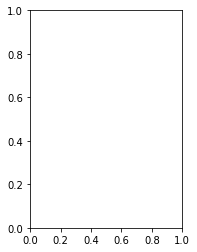

In [50]:
param_raw = trainHyperParameters(data_ag_reord, y_ag)


In [142]:
param_raw_best = getBestParams(param_raw)
param_raw_best

[ 0.78228979  0.52694954  0.57730933  2.         50.         10.        ]


[2, 50, 10]

In [180]:
#Predict using ASV tables
importlib.reload(hf)
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


f = plt.figure(figsize=(15,5))
m, auc, auc_train, fpr, tpr, prec, f1, f2, feat_imp_embed= hf.predictIBD(X_train = hf.asinh(data_ag_reord), y_train = y_ag, X_test = hf.asinh(otu_hut), y_test = y_hut,
                                                                     max_depth = param_raw_best[0],
                                                                         n_estimators = param_raw_best[1],
                                                                         weight = param_raw_best[2],
                                                                     plot= False, plot_pr = False, flipped = False)
#f.savefig("../figures/curves_ag_half_asin.pdf")


#probs = m.predict_proba(hf.asinh(otu_half))
preds = m.predict(hf.asinh(otu_hut))
#print(preds)
y_flipped = y_hut
print("f1", f1)
print("f2" , f2)
print("Accuracy", np.sum( preds == y_flipped) / len(y_flipped) )
print("Precision: ", precision_score(y_flipped, preds))
print("Recall: ", recall_score(y_flipped, preds))
print("0 Precision: ", precision_score([1 - i for i in y_hut], 1 - preds))
print("0 Recall: ", recall_score([1 - i for i in y_hut], 1 - preds))
print(preds)

f1 0.0
f2 0.0
Accuracy 0.2131979695431472
Precision:  0.0
Recall:  0.0
0 Precision:  0.2131979695431472
0 Recall:  1.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]


<Figure size 1080x360 with 0 Axes>

2 50 1	2 50 10	2 50 20	2 95 1	2 95 10	2 95 20	2 140 1	2 140 10	2 140 20	2 185 1	2 185 10	2 185 20	4 50 1	4 50 10	4 50 20	4 95 1	4 95 10	4 95 20	4 140 1	4 140 10	4 140 20	4 185 1	4 185 10	4 185 20	6 50 1	6 50 10	6 50 20	6 95 1	6 95 10	6 95 20	6 140 1	6 140 10	6 140 20	6 185 1	6 185 10	6 185 20	8 50 1	8 50 10	8 50 20	8 95 1	8 95 10	8 95 20	8 140 1	8 140 10	8 140 20	8 185 1	8 185 10	8 185 20	

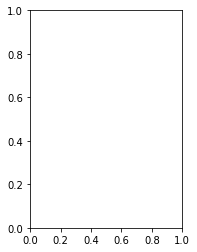

In [56]:
param_embed = trainHyperParameters(embedded_ag, y_ag)

In [144]:
param_embed_best = getBestParams(param_embed)
param_embed_best

[  0.79824266   0.51181867   0.38219409   4.         185.
  20.        ]


[4, 185, 20]

In [182]:
#Embedded data: 97id
importlib.reload(hf)
f = plt.figure(figsize=(15,5))
m_embed, auc, auc_train, fpr, tpr, prec, f1, f2, feat_imp_embed = hf.predictIBD(X_train = embedded_ag, y_train = y_ag, X_test = embedded_97, y_test = y_hut, 
                                                                            max_depth = param_embed_best[0],
                                                                                n_estimators = param_embed_best[1],
                                                                                weight = param_embed_best[2],
                                                                            plot= False, plot_pr = False, flipped = False)

preds = m_embed.predict(embedded_97)
y_flipped = y_hut

print("f1", f1)
print("f2" , f2)
print("Accuracy", np.sum(preds == y_flipped) / len(y_flipped) )
print("Precision: ", precision_score(y_flipped, preds))
print("Recall: ", recall_score(y_flipped, preds))

print("predictions: " + str(preds))

f1 0.2747252747252747
f2 0.19319938176197837
Accuracy 0.3299492385786802
Precision:  0.9259259259259259
Recall:  0.16129032258064516
predictions: [0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0
 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0]


<Figure size 1080x360 with 0 Axes>

In [181]:
#Embedded data: 99id
importlib.reload(hf)
f = plt.figure(figsize=(15,5))
m_embed, auc, auc_train, fpr, tpr, prec, f1, f2, feat_imp_embed = hf.predictIBD(X_train = embedded_ag, y_train = y_ag, X_test = embedded_99, y_test = y_hut, 
                                                                            max_depth = param_embed_best[0],
                                                                                n_estimators = param_embed_best[1],
                                                                                weight = param_embed_best[2],
                                                                            plot= False, plot_pr = False, flipped = False)

preds = m_embed.predict(embedded_99)
y_flipped = y_hut

print("f1", f1)
print("f2" , f2)
print("Accuracy", np.sum(preds == y_flipped) / len(y_flipped) )
print("Precision: ", precision_score(y_flipped, preds))
print("Recall: ", recall_score(y_flipped, preds))

print("predictions: " + str(preds))

f1 0.2747252747252747
f2 0.19319938176197837
Accuracy 0.3299492385786802
Precision:  0.9259259259259259
Recall:  0.16129032258064516
predictions: [0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0
 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0]


<Figure size 1080x360 with 0 Axes>

In [183]:
#Embedded data: 100id
importlib.reload(hf)
f = plt.figure(figsize=(15,5))
m_embed, auc, auc_train, fpr, tpr, prec, f1, f2, feat_imp_embed = hf.predictIBD(X_train = embedded_ag, y_train = y_ag, X_test = embedded_100, y_test = y_hut, 
                                                                            max_depth = param_embed_best[0],
                                                                                n_estimators = param_embed_best[1],
                                                                                weight = param_embed_best[2],
                                                                            plot= False, plot_pr = False, flipped = False)

preds = m_embed.predict(embedded_100)
y_flipped = y_hut

print("f1", f1)
print("f2" , f2)
print("Accuracy", np.sum(preds == y_flipped) / len(y_flipped) )
print("Precision: ", precision_score(y_flipped, preds))
print("Recall: ", recall_score(y_flipped, preds))

print("predictions: " + str(preds))

print(preds == y_hut)
print(y_hut)

f1 0.2651933701657459
f2 0.18575851393188855
Accuracy 0.3248730964467005
Precision:  0.9230769230769231
Recall:  0.15483870967741936
predictions: [0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0
 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0]
[False False False  True  True False False False False False  True  True
 False False False False False  True  True False False  True  True False
 False False  True  True False False  True False  True False False False
 False False False  True  True  True  True  True False False  True  True
 False False  True False False False  True  True False False  True False
 False False False False  True  True  True  True  True  True False False
 False False  T

<Figure size 1080x360 with 0 Axes>

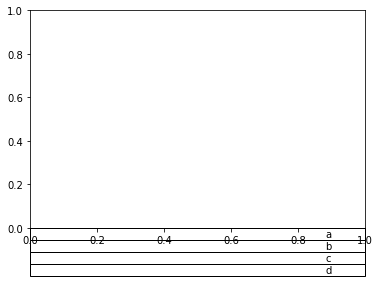

In [87]:
fig = plt.figure()
plt.table(cellText = ['a', 'b', 'c', 'd'])